<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/main/(Original_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -rf /content/data
!cp -r /content/drive/MyDrive/Objectdetection/data_13 /content

In [ ]:
!rm -rf /content/data/.ipynb_checkpoints
!rm -rf /content/data/test/.ipynb_checkpoints
!rm -rf /content/data/train/.ipynb_checkpoints

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [ ]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
################################################## DEV MODE ##########################################
# annot_path = '/content/data/train/annotations/annotation000.xml'

# tree = ET.parse(annot_path)
# root = tree.getroot()

# boxes = list()
# labels = list()
# for obj in root.findall('.//object'):
#     label = obj.find('name').text
#     box = obj.find('bndbox')
#     xmin = int(box.find('xmin').text)
#     ymin = int(box.find('ymin').text)
#     xmax = int(box.find('xmax').text)
#     ymax = int(box.find('ymax').text)
#     coors = [xmin, ymin, xmax, ymax]
#     boxes.append(coors)
#     labels.append(label)

# num_objs = len(labels)
# boxes = torch.as_tensor(boxes, dtype=torch.float32)
# labels = torch.as_tensor(labels, dtype=torch.int64)
# # image_id = torch.tensor([idx])
# area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])



################################################## DEV MODE ############################################

ValueError: ignored

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 57.5MB/s]


In [ ]:
model

In [ ]:
def getDroneObjectDetectionInstance():
    model = fasterrcnn_resnet50_fpn(weights="DEFAULT")
    num_classes=5
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [ ]:
model = getDroneObjectDetectionInstance()

In [ ]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

dataset = CityDataset('/content/data/train', get_transform(train=True))
dataset_test = CityDataset('/content/data/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_4,scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

num_epochs = 15

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/16]  eta: 0:00:33  lr: 0.000676  loss: 3.6894 (3.6894)  loss_classifier: 1.7133 (1.7133)  loss_box_reg: 0.7037 (0.7037)  loss_objectness: 1.1413 (1.1413)  loss_rpn_box_reg: 0.1311 (0.1311)  time: 2.0712  data: 0.5381  max mem: 12014
Epoch: [0]  [10/16]  eta: 0:00:09  lr: 0.007336  loss: 1.7724 (2.1305)  loss_classifier: 0.8405 (1.0248)  loss_box_reg: 0.6881 (0.6686)  loss_objectness: 0.1891 (0.3511)  loss_rpn_box_reg: 0.0843 (0.0860)  time: 1.5544  data: 0.0747  max mem: 12172
Epoch: [0]  [15/16]  eta: 0:00:01  lr: 0.010000  loss: 1.5092 (1.9095)  loss_classifier: 0.6461 (0.8715)  loss_box_reg: 0.6378 (0.6686)  loss_objectness: 0.1611 (0.2841)  loss_rpn_box_reg: 0.0796 (0.0854)  time: 1.5116  data: 0.0584  max mem: 12172
Epoch: [0] Total time: 0:00:24 (1.5251 s / it)
creating index...
index created!
Test:  [0/3]  eta: 0:00:02  model_time: 0.3374 (0.3374)  evaluator_time: 0.0842 (0.0842)  time: 0.8853  data: 0.4590  max mem: 12172
Test:  [2/3]  eta: 0:00:00  model_time: 

In [ ]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 512, 512])
0.1477649211883545


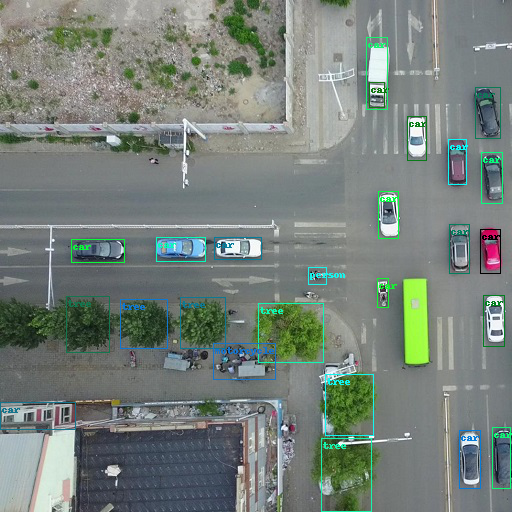

In [ ]:
img, time_taken = get_inference('/content/test1.jpg', 0.5, model)
print(time_taken)
img.show()

In [ ]:
torch.save(model.state_dict(), '/content/model_best_current.pt')

In [ ]:
!cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model.pt'))
model1.to(device)
model1.eval()

In [ ]:
video_path = '/content/video_preview_h264.mp4'

import cv2
vid = cv2.VideoCapture(video_path)

In [ ]:
labels =   {
        1:'person',
        2:'tree',
        3:'car',
        4:'motorcycle'
    }

In [ ]:
ret, frame = vid.read()

In [ ]:
video_path = '/content/video_preview_h264.mp4'
import cv2
vid = cv2.VideoCapture(video_path)

for ii in range(40):
    ret, frame = vid.read()
    orig_size = frame.shape
    frame = cv2.resize(frame, (512, 512))
    frame = torch.from_numpy(frame)
    frame = frame.permute(2, 0, 1)


    print(frame.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(frame/255).to(device)])
        
    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    idx = next(x for x, val in enumerate(scores) if val < 0.6)
    output = draw_bounding_boxes(frame.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    
    cv2.imshow(out)

torch.Size([3, 512, 512])


DisabledFunctionError: ignored